# JEM092 Asset Pricing - Homework 1
### Summer Semester 2021/2022

### Authors: *Petr Čala, Tereza Čechová, Vilém Krejcar*
___

## Task 1 - Downloading data

First things first, we install and load the necessary packages. Then we arbitrarily set a seed for reproducibility.

In [2]:
# Required packages
packages <- c("quantmod", "tseries", "dplyr", "stringr", "xml2", "qdapRegex", "rvest", "httr", "PortfolioAnalytics",
             "timeSeries")

# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
  print(paste("Installing package ", packages[!installed_packages],"...", sep = ""))
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))
rm(list = ls()) #Clean environment

# Miscellaneous
options(repr.plot.width = 6, repr.plot.height = 5)
set.seed(420)

### Groundwork

A bit of groundwork and data preprocessing is in order. These steps either follow the seminar or are a way of keeping the process clean and replicable, so there is not much to comment.

In [3]:
# Static variables
group_id <- "61505008"
required_file_names <- c("data_download", "rand_download", "rand_seminar")
exp_len <- 20 #Number of stocks to be analyzed
range_from <- '2007-01-01'
range_to <- '2022-02-28'
cap_base <- 'https://www.macrotrends.net/assets/php/market_cap.php?t=' #Site for market capitalization scraping
book_value_base_1 <- 'https://www.macrotrends.net/assets/php/fundamental_iframe.php?t=' #Site for book value page scraping (p1)
book_value_base_2 <- '&type=price-book&statement=price-ratios&freq=Q' #(p2)

In [4]:
# Assert presence of necessary files
missing = 0
for (i in required_file_names) {
    name <- paste(group_id, "_", i, ".csv", sep = "")
    if (!name %in% list.files()) {
        print(paste("File ", name, " is missing from the folder.", sep = ""))
        missing <- missing + 1
    }
}
if (missing == 0) {
    print('All required files were located successfully.')
}

[1] "File 61505008_rand_download.csv is missing from the folder."


In [5]:
# A function for loading the tickers from a file
getTickers <- function(file_name) {
    tickers <- as.character(read.csv(paste(group_id, "_", file_name, ".csv", sep = ""))[,2]) # Load the tickers
    if (length(tickers) != exp_len) {
        print(paste("There seem to be some missing tickers. There should be ", exp_len, " of them in total.", sep = ""))
    }
    return(tickers)
}
tickers <- getTickers("rand_download") # We of course load the tickers as so

### Obtaining the *daily closed price* and *volume traded* data

The process is straightforward - we use the *getSymbols* function from the *quantmod* package to *GET* data from yahoo for each of the stock through *lapply*. We then subset for the desired date range and extract the two columns with **closed price** and **volume traded** information.

In [6]:
# A simple function for extracting the Yahoo data
getYahooData <- function(tickers, range_from, range_to) {
    options("getSymbols.warning4.0"=FALSE)
    # Loading and preprocessing the Yahoo data for the specified date range
    data_yahoo <- lapply(tickers, function(y){
        getSymbols(y, src = "yahoo", from = range_from, to = range_to, auto.assign = FALSE, warnings = FALSE)
    })
    names(data_yahoo) <- tickers

    # Discard all columns but the ones including closed price and volume traded
    data_yahoo <- lapply(names(data_yahoo), function(y){
        data_yahoo[[y]][,c(paste0(y, '.Adjusted'), paste0(y, '.Volume'))]
    })
    names(data_yahoo) <- tickers
    print('Yahoo data succesfully extracted.')
    return(data_yahoo)
}

In [7]:
print('Extracting Yahoo data...')
data_yahoo <- getYahooData(tickers, range_from, range_to)

[1] "Extracting Yahoo data..."
[1] "Yahoo data succesfully extracted."


### Obtaining the *Market capitalization* data

The way we decided to tackle this problem was to use the suggested site *macrotrends.net*, where we found out the pattern under which the market capitalization data is stored for each stock.

From here, we found out the *chartData* variable in the source code of the page, under which the data is stored, although to the user only a visual display is shown. We then download the page, extract the string, locate its parts by means of pattern recognition, and finally transform this information into a dataframe. That we do for each stock, automatically and in a generalizable way, of course.

In [8]:
# Define a ticker and the site where it should be extracted from and return a reponse in form of a HTML
extractMarketCap <- function(cap_base, ticker) {
    cap_path <- paste(cap_base, ticker, sep = '')
    cap_page <- read_html(cap_path)
    cap_raw <- cap_page %>% 
        rvest::html_nodes('body') %>% 
        rvest::html_element('script') %>%
        rvest::html_text()
    cap_str <- toString(ex_between(cap_raw, left = 'chartData = [', right = ']'))
    return(cap_str)
}

# A function for transforming the raw html into a data frame
createMarketCapDf <- function(input_str, ticker) {
    pattern_dates <- "([0-9]{4})[-]([0-9]{2})[-]([0-9]{2})"
    pattern_values <- "\\d+([.]\\d+)?(?=\\})"
    
    dates <- stringr::str_extract_all(input_str, pattern_dates)[[1]]
    values_raw <- stringr::str_extract_all(input_str, pattern_values)[[1]]
    values <- unlist(lapply(values_raw, as.numeric))
    
    df <- data.frame(values, row.names = dates)
    colnames(df) <- c(ticker)
    return(df)
}

# Run a for loop across all tickers, generating a data frame with market cap info for each stock
getMarketCapData <- function(cap_base, tickers) {
    df_out <- list()
    print('Extracting market capitalization data for the desired tickers...')
    for (ticker in tickers) {
        raw_data <- extractMarketCap(cap_base, ticker)
        df <- createMarketCapDf(raw_data, ticker)
        df <- subset(df, as.Date(rownames(df)) < as.Date(range_to) &
                         as.Date(rownames(df)) >= as.Date(range_from))
        df_out[[ticker]] <- df
    }
    print('Data extracted succesfully.')
    return(df_out)
}

Running the actual process...

In [9]:
if (!'tickers' %in% ls()) {
    ticker <- getTickers("rand_download") #Load the tickers if they are not loaded into the environment
}
data_market_cap <- getMarketCapData(cap_base, tickers)
# In order to extract individual stocks:
# data_market_cap[['AAPL']], data_market_cap[['ADBE']], ...

[1] "Extracting market capitalization data for the desired tickers..."
[1] "Data extracted succesfully."


### Obtaining the *Book value per Share* data

The process is going to be very similar to the previous case. We use the base string (defined in the static variables section) to find out the location of the data we need. We realized that the **page structure is nearly the same**, although there are 3 graphs instead of one. We locate the one we need (marked by *v2*) using pattern recognition, extract the data, and transfrom it the same way as before, yielding the result - ***data_book_value***.

*Note:* We found out, that in the aforementioned figures, the last observation for *Book value per Share*, is missing, although it is available for the other two metrics. We take this as given and write but a simple warning to let the user know that it is indeed so.

In [10]:
# Define a ticker and the site where it should be extracted from and return a reponse in form of a HTML
extractBookValue <- function(book_value_base_1, book_value_base_2, ticker) {
    bv_path <- paste(book_value_base_1, ticker, book_value_base_2, sep = '')
    bv_page <- read_html(bv_path)
    bv_raw <- bv_page %>% 
        rvest::html_nodes('body') %>% 
        rvest::html_element('script') %>%
        rvest::html_text()
    bv_str <- toString(ex_between(bv_raw, left = 'chartData = [', right = ']'))
    return(bv_str)
}

# A function for transforming the raw html into a data frame
createBookValueDf <- function(input_str, ticker) {
    pattern_dates <- "([0-9]{4})[-]([0-9]{2})[-]([0-9]{2})"
    pattern_values <- "(?<=\\p{quotation mark}v2\\p{quotation mark}\\:)((-)?\\d+([.]\\d+)?(?=,))"
    
    dates <- stringr::str_extract_all(input_str, pattern_dates)[[1]]
    values_raw <- stringr::str_extract_all(input_str, pattern_values)[[1]]
    values <- unlist(lapply(values_raw, as.numeric))
    
    while (length(dates) > length(values)) { #More dates than book value observations - should be no missing in between
        print(paste('Book value data is missing for stock', ticker, "on date", dates[length(dates)], sep = " "))
        dates <- dates[-length(dates)] #Remove the last date
    }
    
    df <- data.frame(values, row.names = dates)
    colnames(df) <- c(ticker)
    return(df)
}

# Run a for loop across all tickers, generating a data frame with book value info for each stock
getBookValueData <- function(book_value_base_1, book_value_base_2, tickers) {
    df_out <- list()
    print('Extracting book value data for the desired tickers...')
    for (ticker in tickers) {
        raw_data <- extractBookValue(book_value_base_1, book_value_base_2, ticker)
        df <- createBookValueDf(raw_data, ticker)
        df <- subset(df, as.Date(rownames(df)) < as.Date(range_to) &
                         as.Date(rownames(df)) >= as.Date(range_from))
        df_out[[ticker]] <- df
    }
    print('Data extracted succesfully.')
    return(df_out)
}

Running the actual process...

In [11]:
if (!'tickers' %in% ls()) {
    ticker <- getTickers("rand_download") #Load the tickers if they are not loaded into the environment
}
data_book_value <- getBookValueData(book_value_base_1, book_value_base_2, tickers)

[1] "Extracting book value data for the desired tickers..."
[1] "Book value data is missing for stock FITB on date 2022-04-05"
[1] "Book value data is missing for stock FFIV on date 2022-04-05"
[1] "Book value data is missing for stock ADBE on date 2022-04-05"
[1] "Book value data is missing for stock TMO on date 2022-04-05"
[1] "Book value data is missing for stock OMC on date 2022-04-04"
[1] "Book value data is missing for stock GOOGL on date 2022-04-05"
[1] "Book value data is missing for stock DGX on date 2022-04-05"
[1] "Book value data is missing for stock AES on date 2022-04-05"
[1] "Book value data is missing for stock TRV on date 2022-04-05"
[1] "Book value data is missing for stock ORCL on date 2022-04-04"
[1] "Book value data is missing for stock PGR on date 2022-04-05"
[1] "Book value data is missing for stock CLX on date 2022-04-05"
[1] "Book value data is missing for stock DHR on date 2022-04-04"
[1] "Book value data is missing for stock ORLY on date 2022-04-05"
[1] "Book

___
As so, the results of the data acquisition should be found under the following variables:
* ***data_yahoo*** - daily closed price and volume traded data from *Yahoo Finance*
* ***data_market_cap*** - Market capitalization data
* ***data_book_value*** - Book value per share data

## Task 2 - Markowitz portfolio

As we were succesful in obtaining the desired data, we shall use them in this exercise.

We **write a function to help us with data transformation**. This allows for simple replicability. This function converts the data to monthly, subsets for the desired range *(years 2015 to 2020)*, and calculates the monthly returns. Returned is an object *data_yahoo_monthly*, which is the transformed dataset.

*Note: Mind that we need to keep the date format as '%Y-%m-%d' for the optimize.portfolio function to work.*

In [12]:
# A simple function for transforming the daily dataset into one displaying monthly data
# Also allows for range subsetting
getYahooDataMonthly <- function(data, range_from = '2015-01-01', range_to = '2022-12-01') {
    data_yahoo_monthly <- list()
    for (stock in names(data)) {
        stock_data <- to.period(data[[stock]], period = 'months')
        new_cols <- c(paste0(stock, '.Monthly.Open'), paste0(stock, '.Monthly.High'),
                                 paste0(stock, '.Monthly.Low'), paste0(stock, '.Monthly.Close'),
                                 paste0(stock, '.Monthly.Volume'))
        colnames(stock_data) <- new_cols
        
        # Subset for the desired date range
        stock_data <- stock_data[index(stock_data) <= as.Date(range_to) &
                                 index(stock_data) >= as.Date(range_from),]
        
        # Calculate monthly returns - we trade off a bit of redundancy for code clarity
        # The subsetting also gets a bit tricky, as generalizing the col names leads to problems with recognition
        returns_col <- paste0(stock,'.Monthly.Returns')
        returns_open <- paste0(stock, '.Monthly.Open')
        returns_close <- paste0(stock, '.Monthly.Close')
        returns_val <- ((stock_data[,returns_close] - stock_data[,returns_open]) / stock_data[,returns_open])
        stock_data$returns_col <- returns_val
        colnames(stock_data) <- append(new_cols, returns_col)
        
        data_yahoo_monthly[[stock]] <- stock_data
    } 
    return(data_yahoo_monthly)
}

In [13]:
if (!'data_yahoo' %in% ls()) {
    data_yahoo <- getYahooData(tickers, range_from, range_to) # Load yahoo data if not in memory
}
data_yahoo_monthly <- getYahooDataMonthly(data_yahoo) # Defaults to range Jan 2015 - Dec 2022

This dataset will later be used in *Task 3* as well, so for this task, we take out only the parts we need, which are the monthly returns. 

Now, we define 3 useful functions to help us form the desired portfolios, and plot their efficient frontier. For this, **we will make use of some parts of the code from Seminar 5**.

In [14]:
# A function for extracting the monthly returns as an data frame - input monthly data from Yahoo Finance
getMonthlyReturns <- function(data) {
    stocks <- names(data)
    getCloseCol <- function(y){
        close_col <- xts(y[,str_detect(colnames(y), "Returns")], order.by=index(y))
        return(close_col)
    }
    returns <- lapply(data, getCloseCol)
    out_data <- do.call(merge, returns)
    colnames(out_data) <- stocks
    return(out_data)
}

# A function for creating a portfolio - input an xts object containing data of monthly returns
getPortfolio <- function(data) {
    stocks <- names(data)
    pspec <- portfolio.spec(assets = stocks)
    pspec <- add.constraint(
        portfolio = pspec,
        type = "leverage",
        min_sum = 0.99,
        max_sum = 1.01
    )
    min_var_portfolio <- add.objective(portfolio = pspec, type = "risk", name = "var")
    optimal_portfolio <- optimize.portfolio(
        R = data,
        portfolio = min_var_portfolio,
        optimize_method = "ROI",
        trace = TRUE
    )
    return(optimal_portfolio)
}

# A function for creating the efficient frontier - input an xts object containing data of monthly returns
getEfficientFrontier <- function(data) {
    stocks <- names(data)
    pspec <- portfolio.spec(assets = stocks)
    pspec <- add.constraint(
        portfolio = pspec,
        type = "leverage",
        min_sum = 0.99,
        max_sum = 1.01
    )
    optimal_portfolio <- getPortfolio(data)
    gmvp_min <- min(optimal_portfolio$weights)
    eff_portfolio <- add.constraint(
        portfolio = pspec,
        type = "box",
        min = gmvp_min,
        max = 1
    )
    eff <- create.EfficientFrontier(R = data, portfolio = eff_portfolio, type = 'mean-var')
    chart.EfficientFrontier(eff, match.col = 'StdDev', type = 'l', RAR.text = 'Sharpe Ratio', pch = 4)
    return(eff)
}

Using these functions, we **create two portfolios, both containing 10 stocks**. Both attain the global minimum variance, which is our goal. The weights under which this is attained can be seen below, along with the fact that **our portfolio is the left-most point** on the plot displaying variance to returns. This is true for both portfolios and serves as a sanity check, as the left-most point represents, by definition of the plot, the portfolio/stock combination with the lowest variance/risk, which is our aim.

In [15]:
# Split the stocks into two portfolios
returnsA <- getMonthlyReturns(data_yahoo_monthly[1:10])
returnsB <- getMonthlyReturns(data_yahoo_monthly[11:20])

portfolioA <- getPortfolio(returnsA)
portfolioB <- getPortfolio(returnsB)

Registered S3 method overwritten by 'ROI':
  method           from              
  print.constraint PortfolioAnalytics


In [16]:
portfolioA
portfolioB

***********************************
PortfolioAnalytics Optimization
***********************************

Call:
optimize.portfolio(R = data, portfolio = min_var_portfolio, optimize_method = "ROI", 
    trace = TRUE)

Optimal Weights:
   FITB    FFIV    ADBE     TMO     OMC   GOOGL     DGX     AES     TRV    ORCL 
-0.1310  0.0452  0.0501  0.2286  0.2992  0.0317 -0.0271 -0.0285  0.1940  0.3278 

Objective Measure:
 StdDev 
0.03974 




***********************************
PortfolioAnalytics Optimization
***********************************

Call:
optimize.portfolio(R = data, portfolio = min_var_portfolio, optimize_method = "ROI", 
    trace = TRUE)

Optimal Weights:
    PGR     CLX     DHR    ORLY     AIZ     SPG     MGM     FRT     RCL    PAYX 
 0.2150  0.3073  0.1689 -0.0070  0.1307 -0.1257  0.1025  0.2639 -0.1069  0.0413 

Objective Measure:
 StdDev 
0.03475 




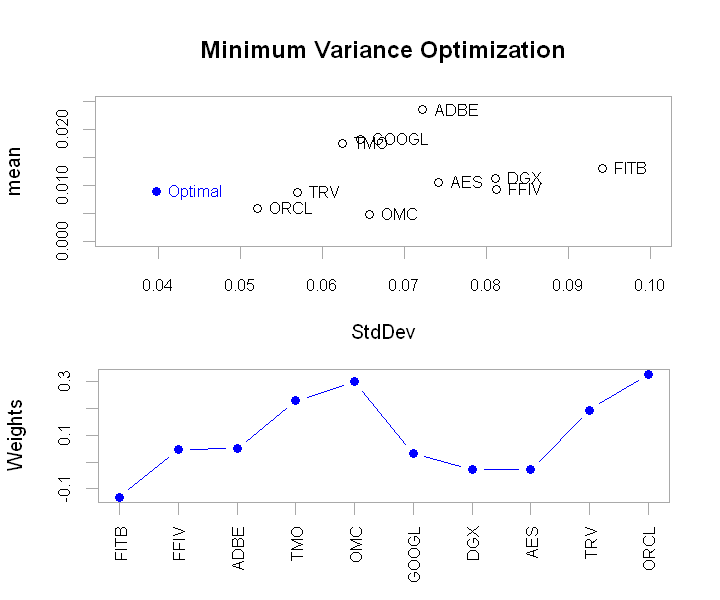

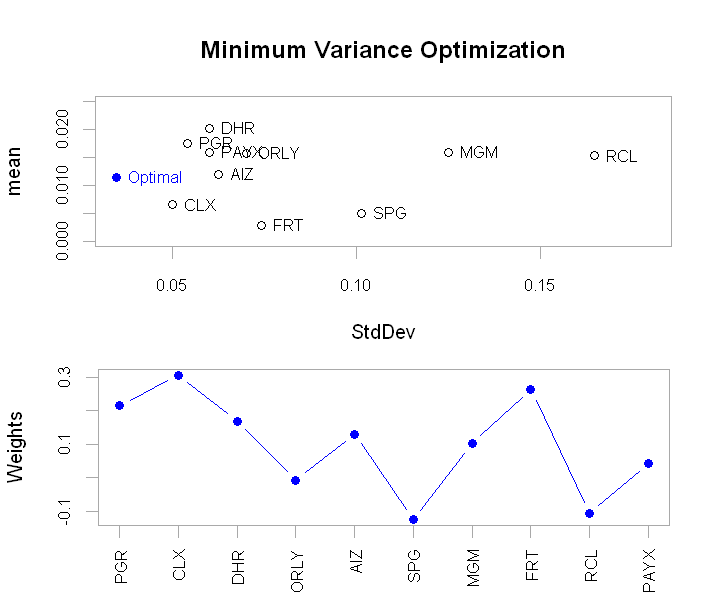

In [17]:
# We can plot the variance-to-return and weights for both of these portfolios
plot(
    portfolioA,
    risk.col = "StdDev",
    return.col = "mean",
    main = "Minimum Variance Optimization",
    chart.assets = TRUE,
    xlim = c(0.035, 0.1),
    ylim = c(0, 0.025)
)

plot(
    portfolioB,
    risk.col = "StdDev",
    return.col = "mean",
    main = "Minimum Variance Optimization",
    chart.assets = TRUE,
    xlim = c(0.035, 0.18),
    ylim = c(0, 0.025)
)

We can see that **portfolio B is a bit less volatile, and yields higher returns**, so this would be the portfolio of our choice. Needless to say, the performance of both of these portfolios is overall quite similar, if we consider the scale.

Below we include **plots of the efficient frontier for both portfolios**. In **portfolio A**, stocks of **Google, Amazon, TMO, TRV or ORCL** could be considered the ones that drive the shape, as they perform better than the other 6 (either yield higher returns for given a certain level of volatility of and less risky/volatile than the other stocks). In **portfolio B**, stocks of **Danaher, PGR or Clorox** seem to be performing the best, for the reasons mentioned above.

Warning message:
"executing %dopar% sequentially: no parallel backend registered"

**************************************************
PortfolioAnalytics Efficient Frontier 
**************************************************

Call:
create.EfficientFrontier(R = data, portfolio = eff_portfolio, 
    type = "mean-var")

Efficient Frontier Points: 25 

**************************************************
PortfolioAnalytics Portfolio Specification 
**************************************************

Call:
portfolio.spec(assets = stocks)

Number of assets: 10 
Asset Names
 [1] "FITB"  "FFIV"  "ADBE"  "TMO"   "OMC"   "GOOGL" "DGX"   "AES"   "TRV"  
[10] "ORCL" 

Constraints
Enabled constraint types
		- leverage 
		- box (with shorting) 


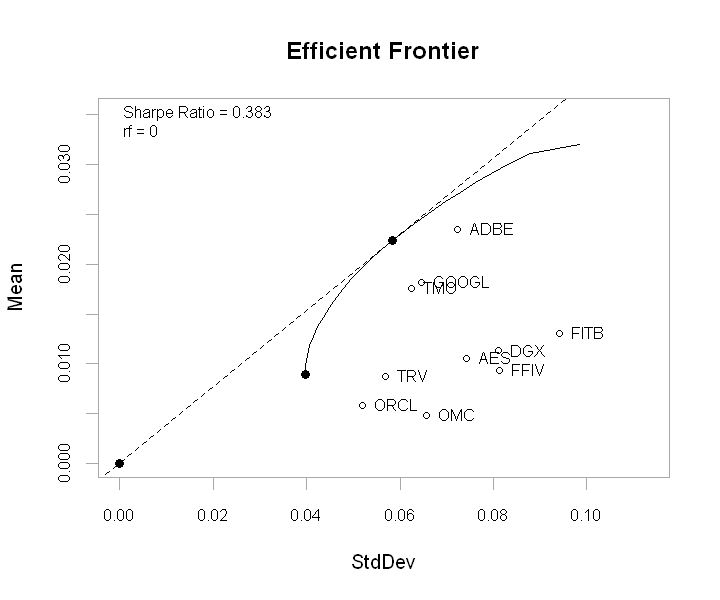

**************************************************
PortfolioAnalytics Efficient Frontier 
**************************************************

Call:
create.EfficientFrontier(R = data, portfolio = eff_portfolio, 
    type = "mean-var")

Efficient Frontier Points: 25 

**************************************************
PortfolioAnalytics Portfolio Specification 
**************************************************

Call:
portfolio.spec(assets = stocks)

Number of assets: 10 
Asset Names
 [1] "PGR"  "CLX"  "DHR"  "ORLY" "AIZ"  "SPG"  "MGM"  "FRT"  "RCL"  "PAYX"

Constraints
Enabled constraint types
		- leverage 
		- box (with shorting) 


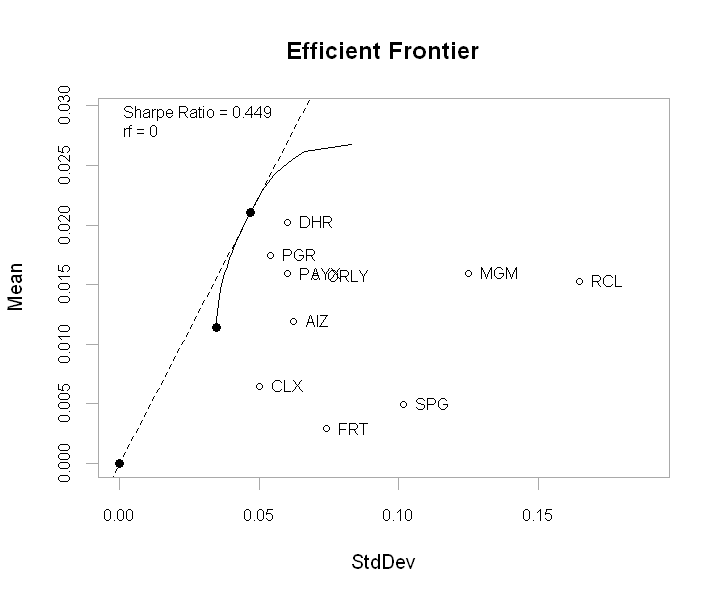

In [18]:
getEfficientFrontier(returnsA)
getEfficientFrontier(returnsB)

## Task 3 - Stock index

We will use the data we obtained during the previous task (*data_yahoo_monthly*) for this. Importantly, **the price that these data display is already the adjusted price**, so stock splits are inherently taken into account. We thus do not need to worry about them when calculating the indices. Considering that Yahoo Finance offers this information automatically, it would seem folly to duplicate work here and adjust the price ourselves.

*Note: It is unclear, whether we should work only with the period 2015-22, or the whole one. Considering the fact that we have the data available, we decided to compute the index for the period 2009-22.*

In [19]:
# Input monthly price data as an xts file and return a simple price weighted index as a data frame
getSimplePriceIndex <- function(data) {
    tickers <- names(data)
    dates <- index(data[[1]])
    getIndex <- function(date) {
        prices <- sapply(data, function(y){
            cols <- str_detect(colnames(y), "Close") # Get .Close columns
            return(y[date,cols])
        })
        prices_sum <- sum(prices)
        weights <- prices/prices_sum
        index <- sum(weights*prices)
        return(index)
    }
    indices <- as.data.frame(sapply(dates, getIndex))
    colnames(indices) <- 'Price weighted index'
    rownames(indices) <- dates
    return(indices)
}

# Input monthly price data and market-capitalization data and
# return a market-capitalization weighted index as a data frame
getMarketCapIndex <- function(data_monthly, data_market_cap) {
    dates <- index(data_monthly[[1]])
    mcapToMonths <- function(mcap_data) {
        stock <- colnames(mcap_data)
        mcap_data <- to.period(mcap_data, period = 'months')
        mcap_data <- mcap_data[,str_detect(colnames(mcap_data), "Close"), drop=FALSE]
        colnames(mcap_data) <- stock
        while (nrow(mcap_data) > length(dates)) { # Redundant rows
            mcap_data <- slice(mcap_data, 2:(n()))
        }
        rownames <- dates
        return(mcap_data)
    }
    mcap_data <- lapply(data_market_cap, mcapToMonths)
    for (data in mcap_data) { # Check that indices match - some datasets get 'monthlified' differently
        check <- sum(index(data) == index(mcap_data[[1]]))
        if (!check) {
            print('Mismatching indices')
            break
        }
    }

    getIndex <- function(date) {
        prices <- sapply(data_monthly, function(y) { # Prices for a given date
            price <- y[as.character(date),str_detect(colnames(y), "Close")]
            return(price) # Price on that day
            })
        total_mkt_cap <- sum(sapply(mcap_data, function(y) { # Total market cap
            mkt_cap <- y[as.character(date),]
        }))
        weights <- sapply(mcap_data, function(y) { # Weights for a given date
            mkt_cap <- y[as.character(date),]
            weight <- mkt_cap/total_mkt_cap
        })
        index <- sum(weights*prices)
        return(index) # Index for a given day
    }
    indices <- as.data.frame(sapply(dates, getIndex)) # Get all indices
    colnames(indices) <- 'MarketCap index'
    rownames(indices) <- dates
    return(indices)
}

# Input monthly price data as an xts file and return an equally weighted index as a data frame
getEqualWeightIndex <- function(data) {
    dates <- index(data[[1]])
    getIndex <- function(date) {
        prices <- sapply(data, function(y){
            cols <- str_detect(colnames(y), "Close") # Get .Close columns
            return(y[date,cols])
        })
        weights <- 1/length(names(data))
        prices_weighted <- prices * weights
        index <- sum(prices_weighted)
        return(index)
    }
    indices <- as.data.frame(sapply(dates, getIndex))
    colnames(indices) <- 'Equally weighted index'
    rownames(indices) <- dates
    return(indices)
}

In [20]:
# Calculate the monthly data for the same range as the MktCap
data_yahoo_monthly_idx <- getYahooDataMonthly(data_yahoo, range_from = '2009-04-30', range_to = '2022-02-25')

# And get the actual indices
price_weighted_index <- getSimplePriceIndex(data_yahoo_monthly_idx)
market_cap_index <- getMarketCapIndex(data_yahoo_monthly_idx, data_market_cap)
equal_weight_index <- getEqualWeightIndex(data_yahoo_monthly_idx)

Once we obtain all 3 indices, we can plot them simultaneously into one plot, which allows us to observe their behavior.

Before going further, **we noticed a discrepancy between the definition of a price weighted index in the setup and in practice**. The way that the setup defines this index involves no actual price weighting, as the divisor is never defined. In practice, the **prices get weighted by a proportion each stock has on the sum of all stock prices for a given period**. This is, then, the definition we use to calculate the index.

As for the actual results, the first two indices behave quite similarly, both indicating a market price that increases over time, which is something we should expect with inflation and market growth. A similar trend can be seen in the equally weighted index, although it displays prices much smaller than its counterpart. A simple explanation for this comes from the definition of the indices, as **larger firms get higher weights in the first two of them (Price weighted \& MktCap)**. Needless to say, larger firms have both higher market capitalization and more expensive stocks.

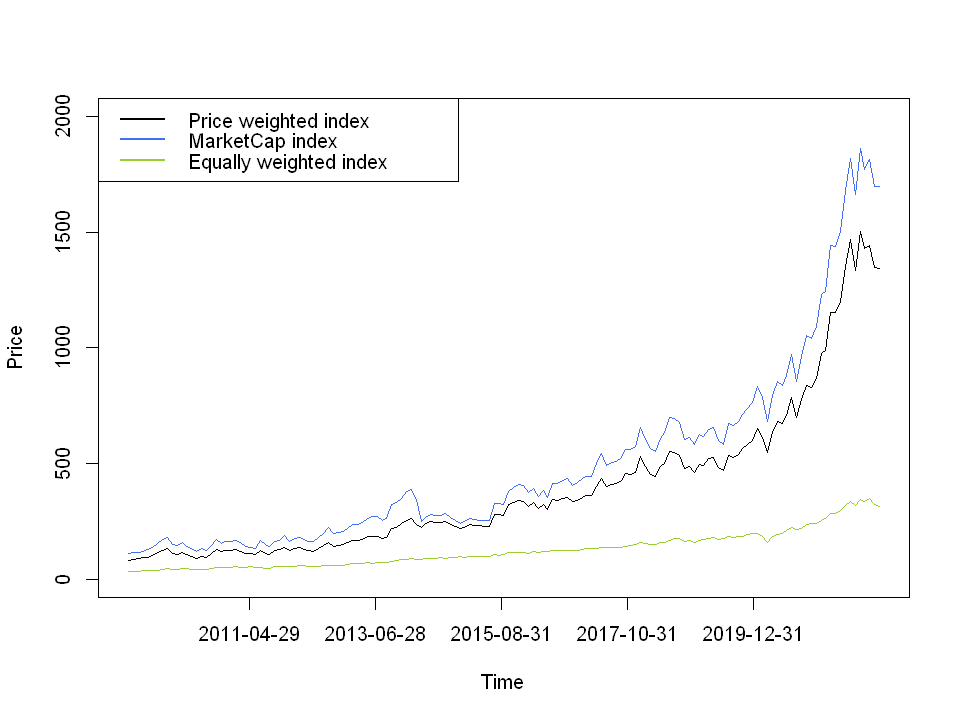

In [21]:
# Plot the indices in a single plot
options(repr.plot.width = 8, repr.plot.height = 6)
               
plot.ts(price_weighted_index, main = "", ylab = "Price", ylim = c(0,2000), xaxt="n")
lines(market_cap_index, col = 'royalblue2')
lines(equal_weight_index, col = 'yellowgreen')
legend("topleft", ncol = 1,
       legend = c(colnames(price_weighted_index), colnames(market_cap_index), colnames(equal_weight_index)),
      col = c('black', 'royalblue2', 'yellowgreen'), lty = 1, lwd = 2, box.col = 'white')
# Axis ticks
getTicks <- function(ticks, idx) { # Number of ticks, index df
    obs <- length(rownames(idx)) / ticks
    iter <- ticks - 1
    ticks <- c()
    for (i in 1:iter) {
        ticks <- append(ticks, obs*i)
    }
    return(ticks)
}
ticks <- getTicks(6, price_weighted_index)
date_axis <- as.Date(rownames(price_weighted_index)[ticks])
axis(side=1, at=ticks, labels=date_axis)